使用两个value模型估计action的价值,取其中小的计算结果,缓解自举

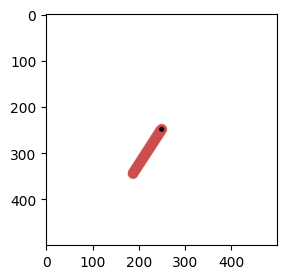

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(
            [action * 2])
        over = terminated or truncated

        #偏移reward,便于训练
        reward = (reward + 8) / 8

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch


class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
            torch.nn.Tanh(),
        )

    def forward(self, state):
        return self.s(state)


model_action = Model()
model_action_delay = Model()
model_action_delay.load_state_dict(model_action.state_dict())

model_action(torch.randn(2, 3))

tensor([[-0.1049],
        [-0.1505]], grad_fn=<TanhBackward0>)

In [3]:
model_value1 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value1_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value1_delay.load_state_dict(model_value1.state_dict())

model_value2 = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value2_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
model_value2_delay.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4)), model_value2(torch.randn(2, 4))

(tensor([[ 0.0432],
         [-0.0194]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0244],
         [-0.1560]], grad_fn=<AddmmBackward0>))

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model_action(torch.FloatTensor(state).reshape(1, 3)).item()

        #给动作添加噪声,增加探索
        action += random.normalvariate(mu=0, sigma=0.2)

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

3.0491358646021984

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
        action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

next_state.shape, len(pool), pool[0]

/tmp/ipykernel_7590/1738991660.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(torch.Size([64, 3]),
 200,
 (array([-0.77460074, -0.6324506 , -0.8910659 ], dtype=float32),
  -0.027735333185845312,
  0.23554229983129993,
  array([-0.8161807, -0.5777967, -1.3737245], dtype=float32),
  False))

In [6]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=5e-3)
optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=5e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.7 + _from.data * 0.3
        _to.data.copy_(value)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)


requires_grad(model_action_delay, False)
requires_grad(model_value1_delay, False)
requires_grad(model_value2_delay, False)

In [7]:
def train_action(state):
    requires_grad(model_action, True)
    requires_grad(model_value1, False)
    requires_grad(model_value2, False)

    #首先把动作计算出来
    action = model_action(state)

    #使用value网络评估动作的价值,价值是越高越好
    input = torch.cat([state, action], dim=1)
    value1 = model_value1(input)
    value2 = model_value2(input)
    loss = -torch.min(value1, value1).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state)

-0.01376472320407629

In [8]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value1, True)
    requires_grad(model_value2, True)

    #计算value
    input = torch.cat([state, action], dim=1)
    value1 = model_value1(input)
    value2 = model_value2(input)

    #计算target
    next_action = model_action_delay(next_state)
    input = torch.cat([next_state, next_action], dim=1)
    with torch.no_grad():
        target1 = model_value1_delay(input)
        target2 = model_value2_delay(input)
    target = torch.min(target1, target2)
    target = target * 0.99 * (1 - over) + reward

    #计算td loss,更新参数
    loss1 = torch.nn.functional.mse_loss(value1, target)
    loss2 = torch.nn.functional.mse_loss(value2, target)

    loss1.backward()
    optimizer_value1.step()
    optimizer_value1.zero_grad()

    loss2.backward()
    optimizer_value2.step()
    optimizer_value2.zero_grad()

    return loss1.item(), loss2.item()


train_value(state, action, reward, next_state, over)

(0.041669800877571106, 0.0335715152323246)

In [9]:
#训练
def train():
    model_action.train()
    model_value1.train()
    model_value2.train()

    #共更新N轮数据
    for epoch in range(200):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #训练模型
            train_action(state)
            train_value(state, action, reward, next_state, over)

        soft_update(model_action, model_action_delay)
        soft_update(model_value1, model_value1_delay)
        soft_update(model_value2, model_value2_delay)

        if epoch % 20 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)


train()

0 400 10.356381916876254
20 4400 59.398461293219114
40 8400 93.9003990491715
60 12400 179.42523248094273
80 16400 178.18461007439137
100 20000 181.7873467513263
120 20000 184.02346289209098
140 20000 181.3078818054768
160 20000 182.84553465177405
180 20000 172.36964748985565


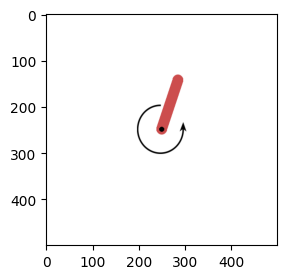

197.61543598839395

In [10]:
play(True)[-1]